In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
low_folder = r"D:\test_development\Battery\data2\Panasonic 18650PF Data original\0degC/"
mid_folder = r"D:\test_development\Battery\data2\Panasonic 18650PF Data original\10degC/"
high_folder = r"D:\test_development\Battery\data2\Panasonic 18650PF Data original\25degC/"
cols = ['V', 'I', 'T']

In [57]:
def butter(x):
    hz = 1
    b, a = scipy.signal.butter(1, 0.005/(hz/2))
    x['V5m'] = scipy.signal.filtfilt(b, a, x['V'])
    x['I5m'] = scipy.signal.filtfilt(b, a, x['I'])
    b, a = scipy.signal.butter(1, 0.0005/(hz/2))
    x['V0.5m'] = scipy.signal.filtfilt(b, a, x['V'])
    x['I0.5m'] = scipy.signal.filtfilt(b, a, x['I'])
    x.drop(columns=['V', 'I'], inplace=True)

def from_mat(raw_file):

    # read mat
    mat = scipy.io.loadmat(raw_file)
    x = pd.DataFrame()
    for i, col in enumerate(mat['meas'][0][0]):
        x = pd.concat([x, pd.DataFrame(col, columns=[i])], axis=1)
    x.drop(columns=[4, 5, 7, 8], inplace=True)

    # set datetime index
    x[0] = x[0].str[0]
    x.loc[x[0].str.len() < 15, 0] = x[0] + ' 12:00:00 AM'
    x.index = pd.to_datetime(x[0], format='%m/%d/%Y %I:%M:%S %p')

    # resample
    x = x.resample('S').mean(numeric_only=True)
    x.dropna(how='all', inplace=True)
    return x

def from_raw(df):
    x = df.copy()

    # if any column keeps unchanged for 300 seconds, this interval will be deleted
    condition = (abs(x - x.shift()) <= 0).any(axis=1)
    duplicates = x[condition].groupby((~condition).cumsum())
    # print(len(duplicates))
    for name, df_type in list(duplicates):
        if len(df_type) > 300:
            x.drop(df_type.index, inplace=True)

    x = x.reset_index(drop=True)
    y = pd.DataFrame(x.pop(3))

    x.columns = cols
    y.columns = ['SOC']

    # normalization
    x = x.apply(lambda row : (row - row.min()) / (row.max() - row.min()))
    y = y / 3 % 1

    butter(x)
    return x, y

def combine_file(folder, excludes = []):
    df = pd.DataFrame()
    for child in os.listdir(folder):
        folderpath = folder + child + '/'
        for filename in os.listdir(folderpath):
            skip = False
            if not filename.endswith('.mat'):
                skip = True
            for exclude in excludes:
                if exclude in filename:
                    print('found', folder)
                    skip = True
                    break
            if skip:
                continue
            file_df = from_mat(folderpath + filename)

            # print(filename, len(file_df))

            df = pd.concat([df, file_df], ignore_index=True)
    return df

found D:\test_development\Battery\data2\Panasonic 18650PF Data original\0degC/
found D:\test_development\Battery\data2\Panasonic 18650PF Data original\10degC/
found D:\test_development\Battery\data2\Panasonic 18650PF Data original\25degC/
363224


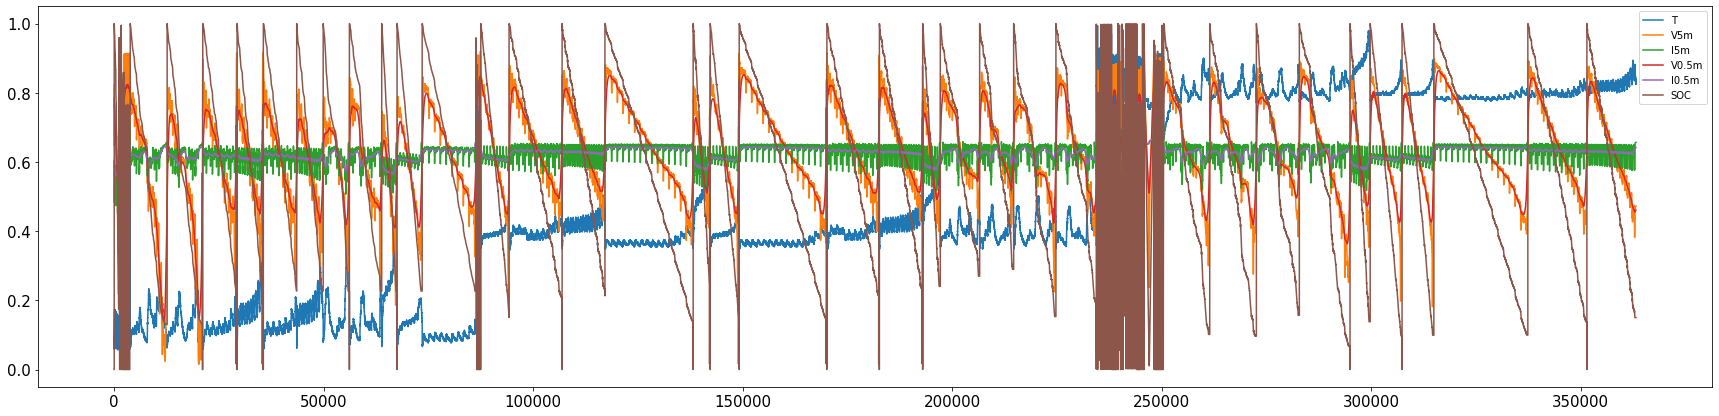

In [59]:
df_new = pd.concat([combine_file(folder, ['Pulse']) for folder in [low_folder, mid_folder, high_folder]], ignore_index=True)
x_df, y_df = from_raw(df_new)

print(len(x_df))
pd.concat([x_df, y_df], axis=1).plot(figsize=(30, 7), fontsize=15)
plt.show()

367063


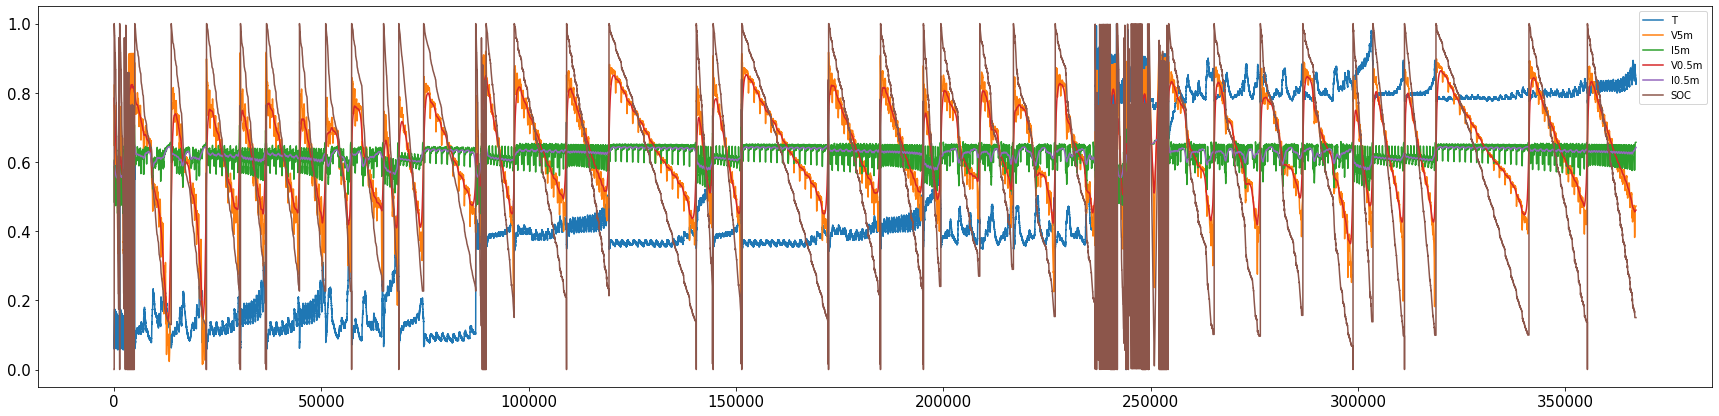

In [30]:
df_new = pd.concat([combine_file(folder) for folder in [low_folder, mid_folder, high_folder]], ignore_index=True)
x_df, y_df = from_raw(df_new)

print(len(x_df))
pd.concat([x_df, y_df], axis=1).plot(figsize=(30, 7), fontsize=15)
plt.show()

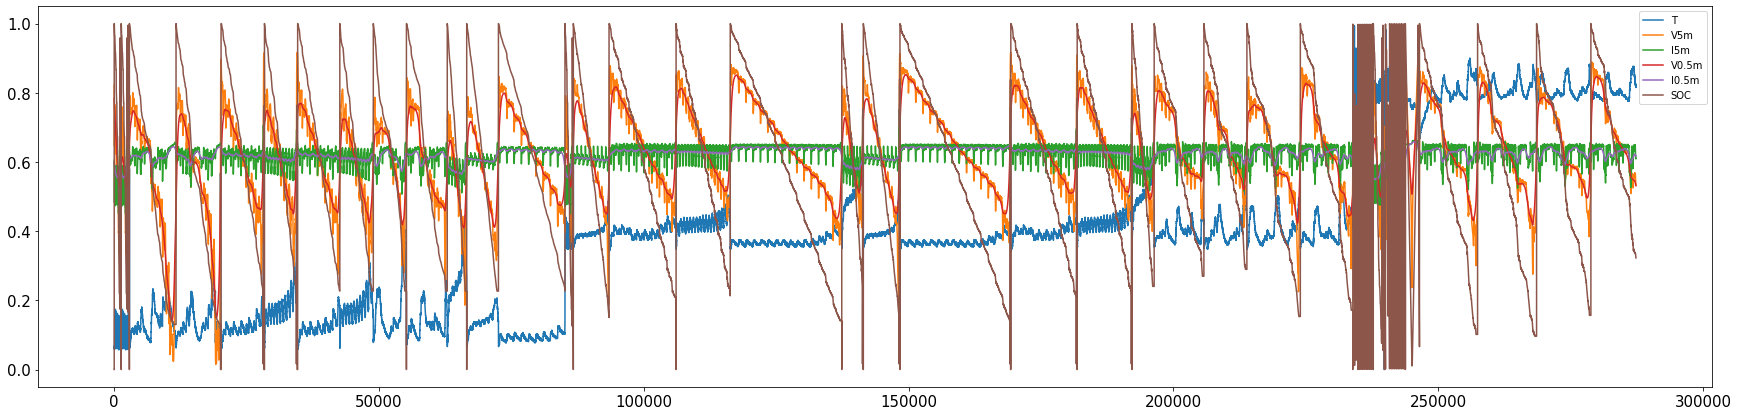

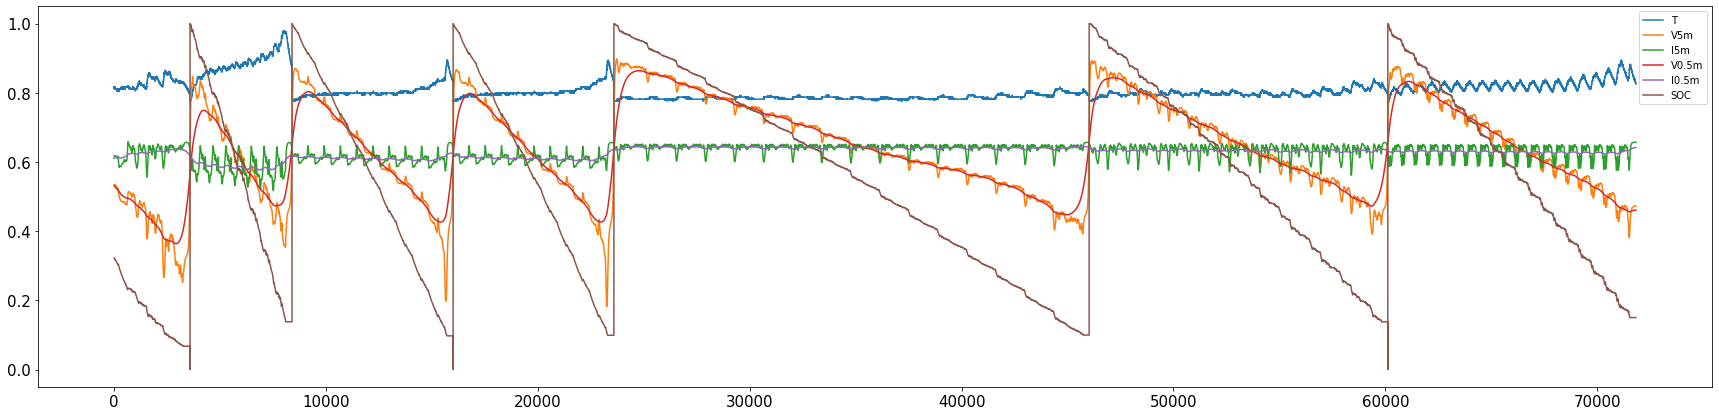

In [6]:
x_train, x_test = train_test_split(x_df, shuffle=False, test_size=0.2)
y_train, y_test = train_test_split(y_df, shuffle=False, test_size=0.2)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

pd.concat([x_train, y_train], axis=1).plot(figsize=(30, 7), fontsize=15)
plt.show()

pd.concat([x_test, y_test], axis=1).plot(figsize=(30, 7), fontsize=15)
plt.show()

In [38]:
def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(21, activation='relu'),
  tf.keras.layers.Dense(19, activation='relu'),
  tf.keras.layers.Dense(1, activation=clipped_relu)
])

model.compile(optimizer='adam',
              loss='mean_squared_error')

history = model.fit(
  x_train.values,
  y_train.values,
  epochs=50,
  validation_split=0.1,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/50
8082/8082 [==============================] - 11s 1ms/step - loss: 0.0075 - val_loss: 0.0045
Epoch 2/50
8082/8082 [==============================] - 10s 1ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 3/50
8082/8082 [==============================] - 11s 1ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 4/50
8082/8082 [==============================] - 10s 1ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 5/50
8082/8082 [==============================] - 11s 1ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 6/50
8082/8082 [==============================] - 11s 1ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 7/50
8082/8082 [==============================] - 11s 1ms/step - loss: 0.0039 - val_loss: 0.0012


In [32]:
def test_eva(x, y):
    model.evaluate(x, y)
    prediction = pd.DataFrame(model.predict(x), columns=['predicted SOC'])

    # Visualising the results
    pd.concat([prediction, y], axis=1).plot(figsize=(16, 4), legend=True)
    plt.show()

2245/2245 [==============================] - 2s 839us/step


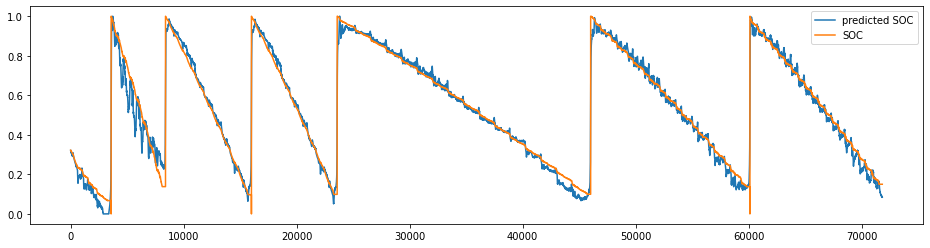

In [39]:
test_eva(x_test, y_test)